<a href="https://colab.research.google.com/github/ajuhz/Artificial-Intelligence/blob/master/Image_Caption_using_CNN_and_RNN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Projects/RNN/Python Proj/image-caption-pytorch-master')

In [ ]:
!pwd

/content/drive/My Drive/Colab Projects/RNN/Python Proj/image-caption-pytorch-master


In [2]:
# all necessary imports at first place
import os, time, json, re
import itertools, argparse, pickle, random

import numpy as np
import pandas as pd
import nltk
from PIL import Image

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, sampler

import torchvision.transforms as T
from torchvision import models
import torchvision

In [3]:
class Flikr8k(Dataset):

    def __init__(self,data_part,data_preproc,transform):
        self.path = data_preproc.path
        self.data_part = data_part
        self.captions, self.image_ids, self.idx_to_word, self.word_to_idx ,self.trn_raw_captions, self.test_raw_captions= \
            data_preproc.get_captions_ids_mapping(self.data_part)
        self.transform = transform
        

    def __getitem__(self, index):
        # feed_forward_net() defined in encode_image.py
        caption = self.captions[index]
        im_id = self.image_ids[index]
        im = Image.open(self.path+'Flicker8k_Dataset//'+im_id)
        if self.transform is not None:
            im = self.transform(im)
       
        return im, torch.LongTensor(caption)

    def __len__(self):
        return len(self.image_ids)

In [4]:
class Data_Preprocessing():
    def __init__(self,path):
        self.path = path
    
    def get_captions_ids_mapping(self,data_part, maxlen=40, threshold=1):
        
        # word_idx_map(), tokenize() defined in tokenize_caption.py
        trn_files, test_files = self.split_image_files() #list of test and train images
        trn_raw_captions, test_raw_captions = self.split_captions(trn_files, test_files)
        idx_to_word, word_to_idx = self.word_idx_map(trn_raw_captions, threshold)
        if data_part == 'train':
            captions, image_ids = self.tokenize(trn_raw_captions, word_to_idx, maxlen)
        if data_part == 'test':
            captions, image_ids = self.tokenize(test_raw_captions, word_to_idx, maxlen)
        return captions, image_ids, idx_to_word, word_to_idx,trn_raw_captions, test_raw_captions
    
    
    def split_captions(self,trn_files, test_files):
        # load raw captions
        raw_f = open(self.path + 'Flickr8k.token.txt', 'r').read().strip().split('\n')
        raw_captions = {}
        for line in raw_f:
            line = line.split('\t')
            im_id, cap = line[0][:len(line[0])-2], line[1]
            if im_id not in raw_captions:
                raw_captions[im_id] = ['<start> ' + cap + ' <end>']
            else:
                raw_captions[im_id].append('<start> ' + cap + ' <end>')
        trn_raw_captions, test_raw_captions = {}, {}
        for im_id in trn_files: trn_raw_captions[im_id] = raw_captions[im_id]
        for im_id in test_files: test_raw_captions[im_id] = raw_captions[im_id]
        return trn_raw_captions, test_raw_captions
    
    def split_image_files(self):
        # load file names
        im_files = os.listdir(self.path + 'Flicker8k_Dataset')
        trn_files = open(self.path+'Flickr_8k.trainImages.txt', 'r').read().strip().split('\n')
        dev_files = open(self.path+'Flickr_8k.devImages.txt', 'r').read().strip().split('\n')
        test_files = open(self.path+'Flickr_8k.testImages.txt', 'r').read().strip().split('\n')
        trn_files += list(set(im_files) - set(trn_files) - set(dev_files) - set(test_files))
        trn_files += dev_files
        return trn_files, test_files
    
    
    def word_idx_map(self,raw_captions, threshold):
        caps = []
        for im in raw_captions:
            for s in raw_captions[im]:
                caps.append(s.split())

        word_freq = nltk.FreqDist(itertools.chain(*caps))
        idx_to_word = ['<pad>'] + [word for word, cnt in word_freq.items() if cnt >= threshold] + ['<unk>']
        word_to_idx = {word:idx for idx, word in enumerate(idx_to_word)}

        return idx_to_word, word_to_idx
    
    def tokenize(self,captions, word_to_idx, maxlen):
        '''
        Inputs:
        - captions: dictionary with image_id as key, captions as value
        - word_to_idx: mapping from word to index
        - maxlen: max length of each sequence of tokens

        Returns:
        - tokens: array of shape (data_size, maxlen)
        - image_ids: list of length data_size, mapping token to corresponding image_id
        '''
        tokens, image_ids = [], []
        for im_id in captions:
            for cap in captions[im_id]:
                token = [(lambda x: word_to_idx[x] if x in word_to_idx else word_to_idx['<unk>'])(w) \
                         for w in cap.split()]
                if len(token) > maxlen:
                    token = token[:maxlen]
                else:
                    token += [0] * (maxlen-len(token))
                tokens.append(token)
                image_ids.append(im_id)
        return np.array(tokens).astype('int32'), np.array(image_ids)

In [5]:
class Data_Loader():
    def __init__(self ,data_preporc ,data_part,transforms=False):
        self.path = data_preporc.path
        self.data_preporc = data_preporc
        self.transforms = transforms
        self.data_part = data_part
        
    def prepare_loader(self,batch_size):
        
        if self.transforms:
            transform = self.transf()
        else:
            transform = None
        rgb_mean = [0.485, 0.456, 0.406]
        rgb_std = [0.229, 0.224, 0.225]
        if self.data_part == 'train':
            data_set = Flikr8k(self.data_part,self.data_preporc, transform=transform['transform_train'])
            loader = DataLoader(data_set, batch_size=batch_size, shuffle=True)
        else:
            data_set = Flikr8k(self.data_part, self.data_preporc,transform=transform['transform'])
            dset_sampler = sampler.SubsetRandomSampler(range(len(data_set)))
            loader = DataLoader(data_set, batch_size=batch_size, sampler=dset_sampler)
        return loader
    
    def transf (self):
        rgb_mean = [0.485, 0.456, 0.406]
        rgb_std = [0.229, 0.224, 0.225]
        transform ={}
        transform['transform_train'] = T.Compose([
                        T.Resize((224, 224)),
                        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                        T.RandomResizedCrop(224, scale=(0.75, 1.0)),
                        T.RandomHorizontalFlip(),
                        T.ToTensor(),
                        T.Normalize(rgb_mean, rgb_std),
                    ])
        transform['transform']= T.Compose([
                        T.Resize((224, 224)),
                        T.ToTensor(),
                        T.Normalize(rgb_mean, rgb_std),
                    ])
        return transform
        
        

In [6]:
class Encoder_Resnet101(nn.Module):
    
    def __init__(self):
        super(Encoder_Resnet101, self).__init__()
        resnet = torchvision.models.resnet101(pretrained=True)
        module_layers = list(resnet.children())
        selected_layers = module_layers[:-1] # removing last 2 layers which are linear classifcation and average pooling
        self.resnet = nn.Sequential(*selected_layers)
        #self.avgpool = nn.AvgPool2d(7) # as per the ResNet Architecture for input (batch_size,3,256,256) o/p of last layer will be (batch_size,2048,8,8)
        # after average pooling shape will be (batch_size,2048,1,1)
        self.fine_tune()
    
    def fine_tune(self,fine_tune=False):
        for p in self.resnet.parameters():
            p.requires_grad = fine_tune
    
    def forward(self,images):
        """
        images size = (batch_size,3,224,224)
        """
        batch_size = images.shape[0]
        global_features = self.resnet(images)
        #global_features = self.avgpool(global_features) # (batch_size,2048,1,1)
        #global_features = global_features.view(batch_size,-1) #(batch_size,2048)
        return global_features

In [7]:
# Designing Decoder with LSTM for Image Caption
"""
Decoder_Lstm(
  (bn_f): BatchNorm1d(2048, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (proj_f): Linear(in_features=2048, out_features=50, bias=True)
  (proj_h): Linear(in_features=2048, out_features=160, bias=True)
  (proj_c): Linear(in_features=2048, out_features=160, bias=True)
  (relu): ReLU(inplace=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (embed): Embedding(9080, 50, padding_idx=0)
  (dropout_emb): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(50, 160, batch_first=True)
  (linear): Linear(in_features=160, out_features=9080, bias=True)
)
"""

class Decoder_Lstm(nn.Module):
    def __init__(self, input_dim,embedding_dim, hidden_dim,vocab_size, num_layers=1, batch_first=True):
        super(Decoder_Lstm,self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.input_dim=input_dim
        #all layers
        self.bn_f = nn.BatchNorm1d(self.input_dim, momentum=0.01)
        self.proj_f = nn.Linear(self.input_dim, self.embedding_dim)
        self.proj_h = nn.Linear(self.input_dim, self.hidden_dim)
        self.proj_c = nn.Linear(self.input_dim, self.hidden_dim)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.2)
        self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.dropout_emb = nn.Dropout(p=0.1)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        
        
        ### additional lines for better performance
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(0, np.sqrt(2./m.in_features))
        
        
    def forward(self, im_feat, word_seq,print_flag=False):
        #step 1
        im_feat = self.bn_f(im_feat)
        if print_flag:
            print('after #step 1: im_feat.shape: {}'.format(im_feat.shape))
        #step 2
        im_hid = self.relu(self.proj_h(im_feat)).unsqueeze(0)
        if print_flag:
            print('after #step 2: im_hid.shape: {}'.format(im_hid.shape))
        #step 3
        im_state = self.relu(self.proj_c(im_feat)).unsqueeze(0)
        if print_flag:
            print('after #step 3: im_state.shape: {}'.format(im_state.shape))
        #step 4 (this cat will be useful once we pass features to all steps)
        h0 = torch.cat((im_hid, ) * self.num_layers, 0)
        if print_flag:
            print('after #step 4: h0.shape: {}'.format(h0.shape))
        #step 5(this cat will be useful once we pass features to all steps)
        c0 = torch.cat((im_state, ) * self.num_layers, 0)
        if print_flag:
            print('after #step 5: c0.shape: {}'.format(c0.shape))
        #step 6
        hidden=(h0, c0)
        
        #step 7
        im_feat = self.relu(self.proj_f(im_feat))
        if print_flag:
            print('after #step 7: im_feat.shape: {}'.format(im_feat.shape))
        #step 8
       
        #step 9
        emb = self.embed(word_seq)
        if print_flag:
            print('after #step 9: word_seq.shape: {}'.format(word_seq.shape))
        #step 10
        emb = self.dropout_emb(emb)
        if print_flag:
            print('after #step 10: emb.shape: {}'.format(emb.shape))
         #step 11
        output, hidden = self.lstm(emb, hidden)
        if print_flag:
            print('after #step 11: output.shape: {}'.format(output.shape))
         #step 12
        scores = self.linear(output)
        if print_flag:
            print('after #step 12: output.shape: {}'.format(output.shape))
         #step 13
        return scores,hidden

In [36]:
# train class

class Train_Model():
    def __init__(self,dataset_loader,**kwargs):
        # hyperparameters
        self.lr_init = kwargs.pop('lr_init', 0.01)
        self.lr_decay = kwargs.pop('lr_decay', 0.1)
        self.step_size = kwargs.pop('step_size', 16)
        self.batch_size = kwargs.pop('batch_size', 32)
        self.print_every = kwargs.pop('print_every', 200)
        self.checkpoint_name = kwargs.pop('checkpoint_name', 'im_caption')
        #Data variables
        self.data = dataset_loader.dataset
        self.vocab_size = len(self.data.idx_to_word)
        self._pad = self.data.word_to_idx['<pad>']
        self._start = self.data.word_to_idx['<start>']
        self._end = self.data.word_to_idx['<end>']
        self.dataset_loader = dataset_loader
        

        #Model variables
        self.model = Decoder_Lstm(2048, 50, 160, vocab_size, num_layers=1)
        self.encoder = Encoder_Resnet101()
        self.encoder.eval()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr_init,momentum=0.9, weight_decay=0.001)
        self.scheduler = StepLR(self.optimizer, step_size=step_size, gamma=lr_decay)
        self.model = self.model.to(device=device)
        self._reset()

        #other variables
        self.path = dataset_loader.dataset.path
        
        
    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        self.best_val_loss = 999.
        self.best_val_bleu = 0.
        self.loss_history = []
        self.val_loss_history = []
        self.bleu_history = []
        self.val_bleu_history = []
        
    def _save_checkpoint(self, epoch, train_loss):
        torch.save(self.model.state_dict(),
            self.path+self.checkpoint_name+'_%.3f_epoch_%d.pth.tar' %(train_loss,epoch))
        checkpoint = {
            'optimizer': str(type(self.optimizer)),
            'scheduler': str(type(self.scheduler)),
            'lr_init': self.lr_init,
            'lr_decay': self.lr_decay,
            'step_size': self.step_size,
            'batch_size': self.batch_size,
            'epoch': epoch,
        }
        with open(self.path+'hyper_param_optim.json', 'w') as f:
            json.dump(checkpoint, f)    

    def train(self,epochs,batch_size,resume_training = False, file_name=None):
        self.encoder = self.encoder.to(device)
        self.model = self.model.to(device)
        t0 = time.time()
        train_loader= self.dataset_loader
        if resume_training:
          pass
          self.model.load_state_dict(torch.load(self.path+file_name))
          with open(self.path+'hyper_param_optim.json','r') as f:
            current_epoch= json.load(f)['epoch']
        for e in range(current_epoch,epochs):
                       
            print('\nEpoch %d / %d:' % (e + 1, epochs))
            self.model.train()

           
            running_loss = 0.

            for t, (ims, captions) in enumerate(train_loader):
               # print('t :{} , loaders.image shape: {} dataloaders.captions shape:{}'.format(t, ims.shape, captions.shape))
                with torch.no_grad():
                    ims = ims.to(device)
                    features = self.encoder(ims).squeeze()

                features = features.to(device=device)
                captions = captions.to(device=device)
                mask = (captions[:, 1:] != self._pad).view(-1)
               # print('mask shape: {}'.format(mask.shape))

                cap_input = captions[:, :-1]
                cap_target = captions[:, 1:]

               # print('cap input shape: {}'.format(cap_input.shape))
               # print('cap target shape: {}'.format(cap_target.shape))
                scores, hidden = self.model(features, cap_input)

              #  print('scores shape: {} hidden shape: {}'.format(scores.shape,hidden[0].shape))
                loss = F.cross_entropy(torch.reshape(scores, (-1, scores.size(2)))[mask],
                                       torch.reshape(cap_target, (-1,))[mask],
                                       size_average=False) / features.size(0)
                if (t + 1) % print_every == 0:
                    print('t = %d, loss = %.4f' % (t+1, loss.item()))

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item() * features.size(0)
                #if t>0 :
                #    break
            
            self.scheduler.step()
            N = len(self.data)
            train_loss = running_loss / N
            #train_bleu = self.check_bleu(train_loader, num_batches=1)
            #val_loss, val_bleu = self.check_bleu(val_loader, num_batches=1, check_loss=True)
            print('Saving model...')
            self._save_checkpoint(e+1, train_loss)

        #self.scheduler.step(val_loss)


        # Checkpoint and record/print metrics at epoch end
        self.loss_history.append(train_loss)
        #self.val_loss_history.append(val_loss)
        #self.bleu_history.append(train_bleu)
        #self.val_bleu_history.append(val_bleu)

        # for floydhub metric graphs
        #print('{"metric": "BLEU.", "value": %.4f, "epoch": %d}' % (train_bleu, e+1))
        #print('{"metric": "Val. BLEU.", "value": %.4f, "epoch": %d}' % (val_bleu, e+1))
        print('{"metric": "Train Loss", "value": %.4f, "epoch": %d}' % (train_loss, e+1))
        #print('{"metric": "Val. Loss", "value": %.4f, "epoch": %d}' % (val_loss, e+1))

#         if val_bleu > self.best_val_bleu:
#             print('updating best val bleu...')
#             self.best_val_bleu = val_bleu
#             if e > 10:
#                 print('Saving model...')
#                 self._save_checkpoint(e+1, val_loss, val_bleu)
#         elif val_loss < self.best_val_loss:
#             print('updating best val loss...')
#             self.best_val_loss = val_loss
#             if e > 10:
#                 print('Saving model...')
#                 self._save_checkpoint(e+1, val_loss, val_bleu)
#         print()
        
          

        time_elapsed = time.time() - t0
        print('Training complete in {:.0f}m {:.0f}s.'.format(time_elapsed // 60, time_elapsed % 60))
        
        
    def check_bleu(self, loader, num_batches, check_loss=False):

        if check_loss:
            self.model.eval()
            loss = 0

        total_score = 0.
        with torch.no_grad():
            for t, (ims, captions) in enumerate(loader):
                ims = ims.to(device)
                features = self.encoder(ims).squeeze()
                gt_captions = self.decode_captions(captions.numpy(), self.data.idx_to_word)

                if check_loss:
                    
                   # loss += self.forward_net(features, captions)
                    features = features.to(device=device)
                    captions = captions.to(device=device)
                    mask = (captions[:, 1:] != self._pad).view(-1)

                    cap_input = captions[:, :-1]
                    cap_target = captions[:, 1:]
                    scores, hidden = self.model(features, cap_input)
                    loss_temp = F.cross_entropy(torch.reshape(scores, (-1, scores.size(2)))[mask],
                                           torch.reshape(cap_target, (-1,))[mask],
                                           size_average=False) / features.size(0)
                    loss +=loss_temp

                sample_captions = self.sample(features)
                sample_captions = self.decode_captions(sample_captions, self.data.idx_to_word)
                # for gt_caption, sample_caption in zip(gt_captions, sample_captions):
                #     total_score += BLEU_score(gt_caption, sample_caption)
                total_score += eval_bleu.calculate(list(map(self.remove_special_tokens, gt_captions)),
                                    list(map(self.remove_special_tokens, sample_captions)))['bleu_1']

                if (t+1) == num_batches:
                    break

        if check_loss:
            loss /= num_batches
            # return loss.item(), total_score / (num_batches*loader.batch_size)
            return loss.item(), total_score / num_batches

        # return total_score / (num_batches*loader.batch_size)
        return total_score / num_batches
    
    

In [37]:
#Evalate class
class Evaluate_Model():
  def __init__(self,train_model):
    self.model = train_model.model.to(device)
    self.encoder = train_model.encoder.to(device)
    self._pad = train_model._pad
    self._start = train_model._start
    self.path = train_model.path


  def decode_captions(self,tokens, idx_to_word):
          '''
          Inputs:
          - tokens: (N, ) or (N, T) array
          - idx_to_word: mapping from index to word
          Returns:
          - decoded: list of decoded sentences
          '''
          singleton = False
          if tokens.ndim == 1:
              singleton = True
              tokens = tokens[None]
          decoded = []
          N, T = tokens.shape
          for i in range(N):
              words = []
              for t in range(T):
                  word = idx_to_word[tokens[i, t]]
                  if word != '<pad>':
                      words.append(word)
                  if word == '<end>':
                      break
              decoded.append(' '.join(words))
          if singleton:
              decoded = decoded[0]
          return decoded

  def remove_special_tokens(self,caption_text):
      return ' '.join([x for x in caption_text.split(' ')
                if ('<end>' not in x and '<start>' not in x and '<unk>' not in x)])
  
  
  
  def sample(self, features, max_length=40, b_size=3, model_mode='nic', search_mode='greedy'):
      
      self.model.eval()
      N = features.size(0)

      if model_mode == 'nic':

          # prepare model input
          features = features.to(device=device)
          features = self.model.dropout(self.model.bn_f(features))
          feeds = torch.ones((N, 1)) * self._start                                       # initial feed, (N, 1)
          feeds = feeds.to(device=device, dtype=torch.long)

          im_hid = self.model.dropout(self.model.relu(self.model.proj_h(features))).unsqueeze(0)
          im_state = self.model.dropout(self.model.relu(self.model.proj_c(features))).unsqueeze(0)
          h0 = torch.cat((im_hid, ) * self.model.num_layers, 0)                          # h0, c0: (L, N, H)
          #h0 = torch.zeros((self.model.num_layers, N, self.model.hidden_dim)).to(device=device)
          c0 = torch.cat((im_state, ) * self.model.num_layers, 0)
          #c0 = torch.zeros(h0.size()).to(device=device)
          hidden = (h0, c0)

          #features = self.model.dropout(self.model.relu(self.model.proj_f(features))).unsqueeze(1)
          #_, hidden = self.model.rnn.lstm(features, hidden)

          if search_mode == 'greedy':
              captions = self._pad * np.ones((N, max_length), dtype=np.int32)
              captions[:, 0] = np.ones(N) * self._start
              for t in range(1, max_length):
                  #word_scores, hidden = self.model.rnn(word_seq=feeds, im_feat=features,     # word_scores: (N, 1, V)
                  #                                     hidden=hidden)
                  # word_scores, hidden = self.model.lst(word_seq=feeds, hidden=hidden)
                  # feeds = torch.argmax(word_scores.squeeze(1), dim=1, keepdim=True)          # feeds: (N, 1)
                  # captions[:, t] = feeds.data.cpu().numpy().ravel()
                  
                  
                  
                  emb = self.model.embed(feeds)
                  emb = self.model.dropout_emb(emb)
                  word_scores, hidden = self.model.lstm(emb, hidden)
                  word_scores = self.model.linear(word_scores)
                  feeds = torch.argmax(word_scores.squeeze(1), dim=1, keepdim=True)
                  captions[:, t] = feeds.data.cpu().numpy().ravel()
      return captions

  def preprocess(self,im):
    rgb_mean = [0.485, 0.456, 0.406]
    rgb_std = [0.229, 0.224, 0.225]
    
    transform = T.Compose([
                    T.Resize((224, 224)),
                    T.ToTensor(),
                    T.Normalize(rgb_mean, rgb_std),
                ])
    return transform(im).unsqueeze(0)


  def get_captions(self):
      raw_f = open(self.path + 'Flickr8k.token.txt', 'r').read().strip().split('\n')
      raw_captions = {}
      for line in raw_f:
          line = line.split('\t')
          im_id, cap = line[0][:len(line[0])-2], line[1]
          if im_id not in raw_captions:
              raw_captions[im_id] = ['<start> ' + cap + ' <end>']
          else:
              raw_captions[im_id].append('<start> ' + cap + ' <end>')
      return raw_captions


  def sample_and_plot(self,im_id):
      #for s in raw_captions[im_id]:
        # print(s)
    # print()
      #encoder = self.encoder
      #model = decoder
      im = Image.open(self.path+'Flicker8k_Dataset//'+im_id)
      im_t = self.preprocess(im).to(device)
      feature = self.encoder(im_t).squeeze().unsqueeze(0)

      s1 = self.sample(feature, search_mode='greedy')
      s1 = self.decode_captions(s1, loader.dataset.idx_to_word)
    # s2 = solver.sample(feature, search_mode='beam', b_size=5)
      #s2 = decode_captions(s2, data.idx_to_word)
    # s3 = solver.sample(feature, search_mode='beam', b_size=10)
    # s3 = decode_captions(s3, data.idx_to_word)
    # s4 = solver.sample(feature, search_mode='beam', b_size=15)
    # s4 = decode_captions(s4, data.idx_to_word)

      print('Greedy:', s1[0])
    # print('B=5:', s2[0])
    # print('B=10:', s3[0])
    # print('B=15:', s4[0])
      plt.imshow(np.array(im))
      plt.axis('off')

In [ ]:
#from data_utils import prepare_loader
#image_path = 'K://Learning & Sharing//AI//Udemy//the-complete-neural-networks-bootcamp-theory-applications//FLICKR8K//data//Flickr8k_Dataset//'

# Setting GPU / CPU as device
if  torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

####################Variables###########
batch_size = 100
epochs = 16
step_size = 16
lr_init = 0.01
lr_decay = 0.01
print_every = 1
vocab_size = 9080
path = '/content/drive/My Drive/Colab Projects/RNN/data/FLICKR8K/images/'
data_part = 'train'
transforms = True
########################################


data_preproc = Data_Preprocessing(path)
loader = Data_Loader(data_preporc=data_preproc,data_part=data_part,transforms=transforms)
loader = loader.prepare_loader(batch_size)

train = Train_Model(loader)
train.train(epochs,batch_size,resume_training = True, file_name = 'manual_checkpoint.pth.tar')
#train.model.load_state_dict(torch.load(path+'manual_checkpoint.pth.tar'))





Epoch 16 / 16:


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


t = 1, loss = 35.1706
t = 2, loss = 34.8637
t = 3, loss = 34.0543
t = 4, loss = 36.6028
t = 5, loss = 36.5966
t = 6, loss = 33.6878
t = 7, loss = 37.4590
t = 8, loss = 34.3441
t = 9, loss = 37.1044
t = 10, loss = 35.8747
t = 11, loss = 36.8875
t = 12, loss = 34.9496
t = 13, loss = 38.0518
t = 14, loss = 40.8644
t = 15, loss = 35.2105
t = 16, loss = 35.8034
t = 17, loss = 35.7719
t = 18, loss = 37.2899


In [19]:
%matplotlib inline
def test_model(im_id,train_model):
  evaluate = Evaluate_Model(train_model=train)
  evaluate.sample_and_plot(im_id)
  print('Reference : ########################')
  for caption in train_model.dataset_loader.dataset.trn_raw_captions[im_id]:
    print(caption)
  print('Reference : ########################')

Greedy: <start> Two dogs are playing in a field . <end>
Reference : ########################
<start> a beagle and a golden retriever wrestling in the grass <end>
<start> Two dogs are wrestling in the grass . <end>
<start> Two puppies are playing in the green grass . <end>
<start> two puppies playing around in the grass <end>
<start> Two puppies play in the grass <end>
Reference : ########################


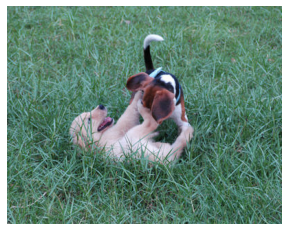

In [20]:
test_model('23445819_3a458716c1.jpg',train)

In [28]:
with open(path+'hyper_param_optim.json','r') as h:
  parameters = json.load(h)

parameters['epoch']

15

In [ ]:
#def _save_checkpoint(self, epoch, train_loss):
torch.save(train.model.state_dict(),
    path+'manual_checkpoint.pth.tar' )
checkpoint = {
    'optimizer': str(type(train.optimizer)),
    'scheduler': str(type(train.scheduler)),
    'lr_init': train.lr_init,
    'lr_decay': train.lr_decay,
    'step_size': train.step_size,
    'batch_size': train.batch_size,
    'epoch': 15,
}
with open(path+'hyper_param_optim.json', 'w') as f:
    json.dump(checkpoint, f)  

In [ ]:
"""
Several functions adapted from

https://github.com/tylin/coco-caption/tree/master/pycocoevalcap/bleu
https://github.com/danieljl/keras-image-captioning/blob/master/keras_image_captioning/preprocessors.py
"""

import math
from collections import defaultdict
import nltk


def BLEU_score(gt_caption, sample_caption):
    """
    gt_caption: string, ground-truth caption
    sample_caption: string, your model's predicted caption
    Returns unigram BLEU score.
    """
    reference = [x for x in gt_caption.split(' ')
                 if ('<end>' not in x and '<start>' not in x and '<unk>' not in x)]
    hypothesis = [x for x in sample_caption.split(' ')
                  if ('<end>' not in x and '<start>' not in x and '<unk>' not in x)]
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, weights = [1])
    return BLEUscore

"""
For the following functions.

Copyright (c) 2015, Xinlei Chen, Hao Fang, Tsung-Yi Lin, and Ramakrishna Vedantam
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.
2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR
ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
(INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND
ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
(INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

The views and conclusions contained in the software and documentation are those
of the authors and should not be interpreted as representing official policies,
either expressed or implied, of the FreeBSD Project.
"""

def remove_special_tokens(caption_text):
    return ' '.join([x for x in caption_text.split(' ')
             if ('<end>' not in x and '<start>' not in x and '<unk>' not in x)])

def precook(s, n=4, out=False):
    """Takes a string as input and returns an object that can be given to
    either cook_refs or cook_test. This is optional: cook_refs and cook_test
    can take string arguments as well."""
    words = s.split()
    counts = defaultdict(int)
    for k in range(1,n+1):
        for i in range(len(words)-k+1):
            ngram = tuple(words[i:i+k])
            counts[ngram] += 1
    return (len(words), counts)

def cook_refs(refs, eff=None, n=4): ## lhuang: oracle will call with "average"
    '''Takes a list of reference sentences for a single segment
    and returns an object that encapsulates everything that BLEU
    needs to know about them.'''

    reflen = []
    maxcounts = {}
    for ref in refs:
        rl, counts = precook(ref, n)
        reflen.append(rl)
        for (ngram,count) in counts.items():
            maxcounts[ngram] = max(maxcounts.get(ngram,0), count)

    # Calculate effective reference sentence length.
    if eff == "shortest":
        reflen = min(reflen)
    elif eff == "average":
        reflen = float(sum(reflen))/len(reflen)

    ## lhuang: N.B.: leave reflen computaiton to the very end!!

    ## lhuang: N.B.: in case of "closest", keep a list of reflens!! (bad design)

    return (reflen, maxcounts)

def cook_test(test, crefs_from_cook, eff=None, n=4):
    '''Takes a test sentence and returns an object that
    encapsulates everything that BLEU needs to know about it.'''

    reflen, refmaxcounts = crefs_from_cook
    testlen, counts = precook(test, n, True)

    result = {}

    # Calculate effective reference sentence length.

    if eff == "closest":
        result["reflen"] = min((abs(l-testlen), l) for l in reflen)[1]
    else: ## i.e., "average" or "shortest" or None
        result["reflen"] = reflen

    result["testlen"] = testlen

    result["guess"] = [max(0,testlen-k+1) for k in range(1,n+1)]

    result['correct'] = [0]*n
    for (ngram, count) in counts.items():
        result["correct"][len(ngram)-1] += min(refmaxcounts.get(ngram,0), count)

    return result

class BleuScorer(object):
    """Bleu scorer.
    """

    __slots__ = "n", "crefs", "ctest", "_score", "_ratio", "_testlen", "_reflen", "special_reflen"
    # special_reflen is used in oracle (proportional effective ref len for a node).

    def copy(self):
        ''' copy the refs.'''
        new = BleuScorer(n=self.n)
        new.ctest = copy.copy(self.ctest)
        new.crefs = copy.copy(self.crefs)
        new._score = None
        return new

    def __init__(self, test=None, refs=None, n=4, special_reflen=None):
        ''' singular instance '''

        self.n = n
        self.crefs = []
        self.ctest = []
        self.cook_append(test, refs)
        self.special_reflen = special_reflen

    def cook_append(self, test, refs):
        '''called by constructor and __iadd__ to avoid creating new instances.'''

        if refs is not None:
            self.crefs.append(cook_refs(refs))
            if test is not None:
                cooked_test = cook_test(test, self.crefs[-1])
                self.ctest.append(cooked_test) ## N.B.: -1
            else:
                self.ctest.append(None) # lens of crefs and ctest have to match

        self._score = None ## need to recompute

    def ratio(self, option=None):
        self.compute_score(option=option)
        return self._ratio

    def score_ratio(self, option=None):
        '''return (bleu, len_ratio) pair'''
        return (self.fscore(option=option), self.ratio(option=option))

    def score_ratio_str(self, option=None):
        return "%.4f (%.2f)" % self.score_ratio(option)

    def reflen(self, option=None):
        self.compute_score(option=option)
        return self._reflen

    def testlen(self, option=None):
        self.compute_score(option=option)
        return self._testlen

    def retest(self, new_test):
        if type(new_test) is str:
            new_test = [new_test]
        assert len(new_test) == len(self.crefs), new_test
        self.ctest = []
        for t, rs in zip(new_test, self.crefs):
            self.ctest.append(cook_test(t, rs))
        self._score = None

        return self

    def rescore(self, new_test):
        ''' replace test(s) with new test(s), and returns the new score.'''

        return self.retest(new_test).compute_score()

    def size(self):
        assert len(self.crefs) == len(self.ctest), "refs/test mismatch! %d<>%d" % (len(self.crefs), len(self.ctest))
        return len(self.crefs)

    def __iadd__(self, other):
        '''add an instance (e.g., from another sentence).'''

        if type(other) is tuple:
            ## avoid creating new BleuScorer instances
            self.cook_append(other[0], other[1])
        else:
            assert self.compatible(other), "incompatible BLEUs."
            self.ctest.extend(other.ctest)
            self.crefs.extend(other.crefs)
            self._score = None ## need to recompute

        return self

    def compatible(self, other):
        return isinstance(other, BleuScorer) and self.n == other.n

    def single_reflen(self, option="average"):
        return self._single_reflen(self.crefs[0][0], option)

    def _single_reflen(self, reflens, option=None, testlen=None):

        if option == "shortest":
            reflen = min(reflens)
        elif option == "average":
            reflen = float(sum(reflens))/len(reflens)
        elif option == "closest":
            reflen = min((abs(l-testlen), l) for l in reflens)[1]
        else:
            assert False, "unsupported reflen option %s" % option

        return reflen

    def recompute_score(self, option=None, verbose=0):
        self._score = None
        return self.compute_score(option, verbose)

    def compute_score(self, option=None, verbose=0):
        n = self.n
        small = 1e-9
        tiny = 1e-15 ## so that if guess is 0 still return 0
        bleu_list = [[] for _ in range(n)]

        if self._score is not None:
            return self._score

        if option is None:
            option = "average" if len(self.crefs) == 1 else "closest"

        self._testlen = 0
        self._reflen = 0
        totalcomps = {'testlen':0, 'reflen':0, 'guess':[0]*n, 'correct':[0]*n}

        # for each sentence
        for comps in self.ctest:
            testlen = comps['testlen']
            self._testlen += testlen

            if self.special_reflen is None: ## need computation
                reflen = self._single_reflen(comps['reflen'], option, testlen)
            else:
                reflen = self.special_reflen

            self._reflen += reflen

            for key in ['guess','correct']:
                for k in range(n):
                    totalcomps[key][k] += comps[key][k]

            # append per image bleu score
            bleu = 1.
            for k in range(n):
                bleu *= (float(comps['correct'][k]) + tiny) \
                        /(float(comps['guess'][k]) + small)
                bleu_list[k].append(bleu ** (1./(k+1)))
            ratio = (testlen + tiny) / (reflen + small) ## N.B.: avoid zero division
            if ratio < 1:
                for k in range(n):
                    bleu_list[k][-1] *= math.exp(1 - 1/ratio)

            if verbose > 1:
                print(comps, reflen)

        totalcomps['reflen'] = self._reflen
        totalcomps['testlen'] = self._testlen

        bleus = []
        bleu = 1.
        for k in range(n):
            bleu *= float(totalcomps['correct'][k] + tiny) \
                    / (totalcomps['guess'][k] + small)
            bleus.append(bleu ** (1./(k+1)))
        ratio = (self._testlen + tiny) / (self._reflen + small) ## N.B.: avoid zero division
        if ratio < 1:
            for k in range(n):
                bleus[k] *= math.exp(1 - 1/ratio)

        if verbose > 0:
            print(totalcomps)
            print("ratio:", ratio)

        self._score = bleus
        return self._score, bleu_list

class Bleu:
    def __init__(self, n=4):
        # default compute Blue score up to 4
        self._n = n
        self._hypo_for_image = {}
        self.ref_for_image = {}

    def compute_score(self, gts, res):

        assert(type(gts) is list)
        assert(type(res) is list)

        bleu_scorer = BleuScorer(n=self._n)
        for hypo, ref in zip(res, gts):
            # Sanity check.
            assert(type(hypo) is str)
            assert(type(ref) is str)

            bleu_scorer += (hypo, [ref])  # (string, list)

        #score, scores = bleu_scorer.compute_score(option='shortest')
        score, scores = bleu_scorer.compute_score(option='closest', verbose=0)
        #score, scores = bleu_scorer.compute_score(option='average', verbose=1)

        # return (bleu, bleu_info)
        return score, scores

    def method(self):
        return "Bleu"

"""
For the following functions.

MIT License

Copyright (c) 2017–2018 Daniel Julius Lasiman

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

class Score(object):
    """A subclass of this class is an adapter of pycocoevalcap."""

    def __init__(self, score_name, implementation):
        self._score_name = score_name
        self._implementation = implementation

    def calculate(self, references, predictions):
        avg_score, scores = self._implementation.compute_score(
                                            references, predictions)
        if isinstance(avg_score, (list, tuple)):
            avg_score = map(float, avg_score)
        else:
            avg_score = float(avg_score)
        return {self._score_name: avg_score}

class BLEU(Score):
    def __init__(self, n=4):
        implementation = Bleu(n)
        super(BLEU, self).__init__('bleu', implementation)
        self._n = n

    def calculate(self, references, predictions):
        """
        Input: two lists of strings
        Return: dict of bleus (bleu_1 to bleu_4)
        """
        name_to_score = super(BLEU, self).calculate(references,
                                                    predictions)
        scores = list(name_to_score.values())[0]
        result = {}
        for i, score in enumerate(scores, start=1):
            name = '{}_{}'.format(self._score_name, i)
            result[name] = score
        return result

eval_bleu = BLEU()